# Naive Bayes
This is a simple model, which takes advantage of the categorical nature of our data. 
Input in the following form:

\["Age" - 20 (int), "Policy_Sales_Channel" - 1 (int), "Gender_Male", "Vehicle_Age_< 1 Year", "Vehicle_Age_> 2 Years", "Vehicle_Damage_Yes", "Previously_Insured_1"\]

Could potentially improve by adding other features (and binning "Annual_Premium"), but may be better to add to an ensemble. Note, that in an ensemble, you will want to use the random train-test split to randomly remove values.

In [2]:
import pandas as pd
import time
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import CategoricalNB
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Чтение данных
data = pd.read_csv('train_short.csv')
# Показать названия всех столбцов
print("\nНазвания столбцов:")
print(data.columns.tolist())
print("\n")
# Показать первые несколько строк
print(data.nunique(axis=0))
dataT = pd.read_csv('test_short.csv')


Названия столбцов:
['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


id                      5000001
Gender                        2
Age                          66
Driving_License               2
Region_Code                  53
Previously_Insured            2
Vehicle_Age                   3
Vehicle_Damage                2
Annual_Premium            48219
Policy_Sales_Channel        149
Vintage                     290
Response                      2
dtype: int64


# Binning Code
If we want to use Annual_Premium, we probably want 10 - 100 in each bin. The problem is not completely visible here, as the class sizes are also very unequal.

In [139]:
count = data.value_counts(subset=['Annual_Premium'], sort = False)

In [145]:
count

Annual_Premium
2630.0            917778
2642.0                 1
2698.0                 1
2730.0                 4
2743.0                 1
                   ...  
522684.0               1
527007.0               1
537303.0               1
538374.0               1
540165.0              34
Name: count, Length: 48219, dtype: int64

In [143]:
x = count.to_numpy()
print(x)

[917778      1      1 ...      1      1     34]


In [147]:
yt = data[['Annual_Premium']]

In [149]:
yv = yt.to_numpy()
print(yv)

[[65101.]
 [58911.]
 [38043.]
 ...
 [28302.]
 [28447.]
 [ 2630.]]


In [155]:
yv = yv.flatten()
print(yv)

[65101. 58911. 38043. ... 28302. 28447.  2630.]


In [157]:
y = np.sort(yv)
print(y)

[  2630.   2630.   2630. ... 540165. 540165. 540165.]


In [165]:
ys = set(yv)
yl = list(ys)
y = np.array(yl)

In [169]:
y = np.sort(y)
print(y)

[  2630.   2642.   2698. ... 537303. 538374. 540165.]


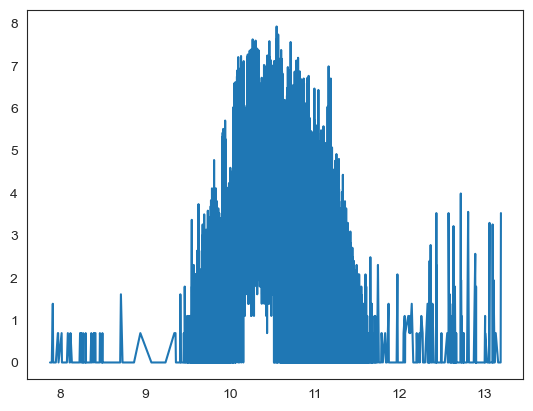

In [181]:
# plot
fig, ax = plt.subplots()

ax.plot(np.log(y[1:]), np.log(x[1:]))

plt.show()

In [193]:
np.exp(11.75)

126753.55900574342

Bin {min} = "< 12500", Bin {max} = "> 250000", Bin {max - 1} = "> 125000"

# Bayes Code

In [5]:
# Удаляем строки с пропущенными значениями (их нет)
data = data.dropna()
dataT = dataT.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000001 entries, 0 to 5000000
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 457.8+ MB


In [6]:
#Оставляем только нужные столбцы
#columns_to_keep = ['Response', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
#columns_to_keep = ['Response', 'Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel']
columns_to_keep = ['Response', 'Gender', 'Age', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
data = data[columns_to_keep]
dataT = dataT[columns_to_keep]

In [31]:
#testD = pd.read_csv('test_short.csv')
#testD = testD[columns_to_keep]
#testD.head()

In [7]:
# One-hot кодирование категориальных признаков
#categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Previously_Insured']
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured']

data = pd.get_dummies(data, columns=categorical_features, drop_first=True)
dataT = pd.get_dummies(dataT, columns=categorical_features, drop_first=True)

length = len(data)

In [36]:
#testD = pd.get_dummies(testD, columns=categorical_features, drop_first=True)

In [8]:
# Нормализация числовых признаков
#numeric_features = ["Age", 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
#numeric_features = ["Age", 'Annual_Premium', 'Policy_Sales_Channel']
numeric_features = ["Age", 'Policy_Sales_Channel']

In [9]:
#Данные несбалансированные
data.Response.value_counts()

Response
0    4384720
1     615281
Name: count, dtype: int64

In [10]:
data[numeric_features] = data[numeric_features].convert_dtypes()
dataT[numeric_features] = dataT[numeric_features].convert_dtypes()
dataT.head()

,Response,Age,Policy_Sales_Channel,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Previously_Insured_1
0,1,61,30,True,False,True,True,False
1,0,44,122,True,False,False,False,True
2,0,25,152,True,True,False,False,False
3,0,26,160,False,True,False,False,True
4,0,28,152,True,True,False,False,True


In [11]:
print(data.nunique(axis=0))

Response                   2
Age                       66
Policy_Sales_Channel     149
Gender_Male                2
Vehicle_Age_< 1 Year       2
Vehicle_Age_> 2 Years      2
Vehicle_Damage_Yes         2
Previously_Insured_1       2
dtype: int64


In [21]:
#count = data.value_counts(subset=['Policy_Sales_Channel'])
#print(count)
#print(np.sum(np.equal(count.to_numpy(), 1)))
#data["Policy_Sales_Channel"].min()

In [12]:
# Renormalization
data["Age"] = data["Age"] - 20
data["Policy_Sales_Channel"] = data["Policy_Sales_Channel"] - 1
dataT["Age"] = dataT["Age"] - 20
dataT["Policy_Sales_Channel"] = dataT["Policy_Sales_Channel"] - 1

In [13]:
data.head()

,Response,Age,Policy_Sales_Channel,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Previously_Insured_1
0,0,1,123,True,False,False,True,False
1,1,23,25,True,False,True,True,False
2,0,5,151,False,True,False,False,True
3,0,15,155,False,False,False,True,False
4,0,16,151,False,False,False,False,True


In [14]:
# Разделение на признаки (X) и целевую переменную (y)
X_train = data.drop('Response', axis=1)
y_train = data['Response']
X_test = dataT.drop('Response', axis=1)
y_test = dataT['Response']

# Разделение на обучающую и тестовую выборки. Только для проверки PCA, потом надо заменить на кросс-валидацию
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [15]:
t_start = time.time()

n_cat = [65, 170, 2, 2, 2, 2, 2]

clf = CategoricalNB(min_categories = n_cat)
clf.fit(X_train, y_train)


t_finish = time.time()
dt = t_finish - t_start
dt2 = dt / 60.

print(clf.score(X_test, y_test))
print("Time: ",  dt, " sec or ", dt2, "min")

0.7415066142725131
Time:  5.4469780921936035  sec or  0.09078296820322672 min


In [17]:
y_lab = clf.predict(X_test)

In [18]:
f1_score(y_test, y_lab)

0.4351341191425862

In [21]:
confusion_matrix(y_test, y_lab)
print(classification_report(y_test, y_lab))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83   5705019
           1       0.30      0.81      0.44    799778

    accuracy                           0.74   6504797
   macro avg       0.63      0.77      0.63   6504797
weighted avg       0.88      0.74      0.78   6504797



In [38]:
#clf.fit(X, y)

In [ ]:
# other variants -- 
# annual premium can be added back in, but needs to be binned
# perhaps accounting for correlation is possible 150 * 66 * 2^5 = 316 800 (out of 5 mil)
# this could be put in an ensemble with another model (like decision tree without policy channel) 

In [100]:
# Сохранение модели в файл
model_filename = "bayes_class_model_001.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)
print(f"Модель сохранена в файл: {model_filename}")

Модель сохранена в файл: bayes_class_model_001.pkl
